In [1]:
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi
!rm -r indonlu
!git clone https://github.com/ezaaputra/indonlu.git

Mounted at /content/drive
Thu May 15 05:54:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

In [2]:
# Install libraries
!pip install emoji
!pip install Sastrawi
!pip install transformers

# Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

# Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


shape: (30000, 2)


<ipython-input-3-d65195627ad4>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette=colors)
<ipython-input-3-d65195627ad4>:20: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  bars = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette=colors)


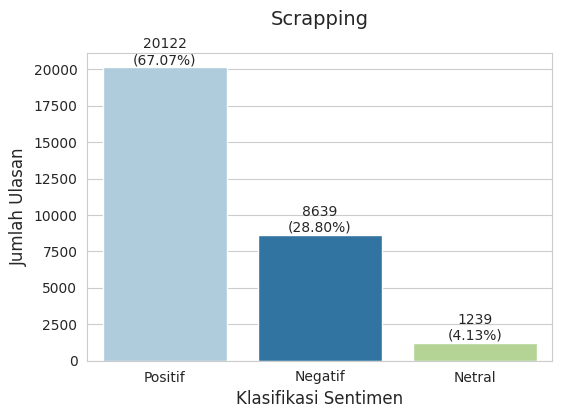

In [3]:
df_path = '/content/bank_reviews_sentimentt.tsv'
stopword_path = '/content/stopwords_id_satya.txt'
kamus_baku_path = '/content/kamuskatabaku.xlsx'

# Import data
df = pd.read_csv(df_path, sep='\t',header=0, names=['review_text', 'category'])
print(f'shape: {df.shape}')
df['category'].value_counts()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sentiment_count = df['category'].value_counts()
sns.set_style('whitegrid')
colors = plt.cm.Paired(range(len(sentiment_count)))

fig, ax = plt.subplots(figsize=(6, 4))
bars = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette=colors)

plt.title('Scrapping', fontsize=14, pad=20)
plt.xlabel('Klasifikasi Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)

total = len(df['category'])
for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()


In [4]:
import pandas as pd
import numpy as np
df_path = '/content/bank_reviews_sentimentt.tsv'
df = pd.read_csv(df_path, sep='\t', header=0, names=['review_text',
'category'])
df.head(50)
# ------ Case Folding --------
# gunakan fungsi Series.str.lower() pada Pandas
df['Case Folding'] = df['review_text'].str.lower()
print('Case Folding Result : \n')
print(df['Case Folding'].head())
print('\n\n\n')

Case Folding Result : 

Seabank                                      sangat membantu
Seabank    bagus sederhana praktis digunakan, suka banget...
Seabank           seabank poko nya sangat membantu bagi kami
Seabank          sangat mudah transaksi terutama di admin 🙏🏻
Seabank                               sangat membantu sekali
Name: Case Folding, dtype: object






In [5]:
import re
import string
import nltk

character = ['.', ',', ';', ':', '-',
             ',', '...', '?', '!', '(', ')', '[', ']', '{', '}', '<', '>', '"', '/', '\'',
             '#', '-', '@',
             'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
             'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
             'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
             'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# hapus karakter yang berulang
def repeatcharClean(text):
    for i in range(len(character)):
        charac_long = 5
        while charac_long > 2:
            char = character[i] * charac_long
            text = text.replace(char, character[i])
            charac_long -= 1
    return text

# fungsi cleaning
def clean_review(text):
    # hapus url
    text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)

    # hapus emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # hapus emotikon
    text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)

    # hapus hashtag
    text = re.sub(r'#(\S+)', r'\1', text)

    # hapus angka dan simbol
    text = re.sub('[^a-zA-Z]+', ' ', text)

    # hapus karakter berulang
    text = repeatcharClean(text)

    # hapus spasi berlebih
    text = re.sub('[ ]+', ' ', text)

    # ubah newline jadi spasi
    text = re.sub(r'\n', ' ', text)

    # hapus tanda baca
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    return text

# 🧩 Taruh fungsi ini sebelum df_v1 dipanggil
def preprocess_v1(df):
    return df  # isi nanti kalau perlu, ini hanya untuk mencegah error

# Proses cleaning
df['cleaning_result'] = df['Case Folding'].apply(lambda x: clean_review(x))
df

print('cleaning result: \n')
print(df['cleaning_result'].head())
print('\n\n\n')

# Panggil (tidak error karena fungsi sudah ada)
df_v1 = preprocess_v1(df)


cleaning result: 

Seabank                                      sangat membantu
Seabank    bagus sederhana praktis digunakan suka banget ...
Seabank           seabank poko nya sangat membantu bagi kami
Seabank            sangat mudah transaksi terutama di admin 
Seabank                               sangat membantu sekali
Name: cleaning_result, dtype: object






In [6]:
import string
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Download the 'punkt_tab' resource
import nltk
nltk.download('punkt_tab')

def tokenization_review(text):
    text = word_tokenize(text)
    return text

df_v1['review_text_tokens'] = df_v1['cleaning_result'].apply(lambda x: tokenization_review(x))
df_v1

print('Tokenizing Result : \n')
print(df_v1['review_text_tokens'].head())
print('\n\n\n')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tokenizing Result : 

Seabank                                   [sangat, membantu]
Seabank    [bagus, sederhana, praktis, digunakan, suka, b...
Seabank    [seabank, poko, nya, sangat, membantu, bagi, k...
Seabank      [sangat, mudah, transaksi, terutama, di, admin]
Seabank                           [sangat, membantu, sekali]
Name: review_text_tokens, dtype: object






In [7]:
import nltk
nltk.download('stopwords')

# ------ Stopword --------
from nltk.corpus import stopwords

# ----------------------- get stopword from NLTK stopword ---------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')

# ---------------------------- manually add stopword --------------------------------
# append additional stopword
list_stopwords.extend([
    "yg", "dg", "rt", "dgn", "ny", "d",
    'klo', 'kalo', 'amp', 'biar', 'bikin', 'bilang',
    'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
    'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
    'jd', 'jgn', 'sdh', 'aja', 'n', 't',
    'nyg', 'hehe', 'pen', 'u', 'nan',
    'loh', 'rt', '&amp', 'yah', 'dr'
])

# ---- add stopword from txt file -----
# read txt stopword using pandas
txt_stopword = pd.read_csv("/content/stopwords_id_satya.txt", names=["stopwords"], header=None)

# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))

# ------------------------------------------------------------
# convert list to dictionary
list_stopwords = set(list_stopwords)

# remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df_v1['Stopword'] = df_v1['review_text_tokens'].apply(stopwords_removal)

print(df_v1['Stopword'].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Seabank                                           [membantu]
Seabank    [bagus, sederhana, praktis, suka, banget, appn...
Seabank                            [seabank, poko, membantu]
Seabank                            [mudah, transaksi, admin]
Seabank                                           [membantu]
Name: Stopword, dtype: object


In [8]:
!pip install Sastrawi
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=df684b09eebb4ae727ac101aad5f44cf99a5a9aa39aafb60c8f99c3cff9e011a
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [9]:
# ------ Stemming --------
# pip install Sastrawi
# pip install swifter

# import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}
for document in df_v1['Stopword']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term, ":", term_dict[term])

print(term_dict)
print("------------------------")

# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df_v1['review_text_tokens_stemmed'] = df_v1['Stopword'].swifter.apply(get_stemmed_term)
print(df_v1['review_text_tokens_stemmed'])


Streaming output truncated to the last 5000 lines.
iklass : iklass
menyangka : sangka
formalitas : formalitas
gam : gam
lese : lese
bintangya : bintangya
dilirik : lirik
asia : asia
ketergantungan : gantung
dollar : dollar
zoal : zoal
menhubungi : menhubungi
costumers : costumers
scanner : scanner
semuajadijago : semuajadijago
kerugian : rugi
balikinya : balik
duitny : duitny
kuno : kuno
pulus : pulus
adik : adik
setelan : setel
moho : moho
perjelas : jelas
selesa : selesa
pswnya : pswnya
pantau : pantau
batasnya : batas
modus : modus
tiddak : tiddak
maksi : maksi
pro : pro
ses : ses
sskit : sskit
pertanhankn : pertanhankn
dancoxcc : dancoxcc
manatp : manatp
loq : loq
melewati : lewat
agood : agood
kembaliu : kembaliu
jl : jl
manukan : manuk
krajan : krajan
tandes : tandes
surabaya : surabaya
sumber : sumber
yaudin : yaudin
pemilihan : pilih
lurah : lurah
taufik : taufik
trimaksh : trimaksh
saua : saua
bagusaku : bagusaku
kasta : kasta
kenutuhan : kenutuhan
perkategori : kategori
membi

/usr/local/lib/python3.11/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/30000 [00:00<?, ?it/s]

Seabank                                               [bantu]
Seabank     [bagus, sederhana, praktis, suka, banget, appn...
Seabank                                [seabank, poko, bantu]
Seabank                             [mudah, transaksi, admin]
Seabank                                               [bantu]
                                  ...                        
Bank Neo                                      [kesini, jijik]
Bank Neo                                     [otw, uninstall]
Bank Neo    [kecewa, ngambil, koin, teman, lg, tolong, neo...
Bank Neo    [aneh, banget, transfer, uang, bank, saqu, rek...
Bank Neo    [komplen, pulsa, masuk, tunggu, jam, hehehhe, ...
Name: review_text_tokens_stemmed, Length: 30000, dtype: object


In [10]:
!pip install openpyxl


In [11]:
normalizad_word = pd.read_excel("/content/kamuskatabaku.xlsx", engine='openpyxl')

normalizad_word_dict = {}
for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df_v1['review_text_normalized'] = df_v1['review_text_tokens_stemmed'].apply(normalized_term)

df_v1['review_text_normalized'].head(10)

df_v1["review_text_normalizedjoin"] = [' '.join(word) for word in df_v1["review_text_normalized"]]


In [12]:
# URL lexicon
positive_url = "https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv"
negative_url = "https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv"

# Load lexicon dari URL
positive_lexicon = set(pd.read_csv(positive_url, sep="\t", header=None)[0])
negative_lexicon = set(pd.read_csv(negative_url, sep="\t", header=None)[0])

# Fungsi analisis sentimen dengan pendekatan lexicon
def sentiment_analysis_lexicon_indonesia(text):
    if isinstance(text, str):
        positive_count = sum(1 for word in text.split() if word in positive_lexicon)
        negative_count = sum(1 for word in text.split() if word in negative_lexicon)
        if positive_count > negative_count:
            return 'positive'
        elif positive_count < negative_count:
            return 'negative'
        else:
            return 'neutral'

# Terapkan ke dataframe
df_v1['label'] = df_v1['review_text_normalizedjoin'].apply(sentiment_analysis_lexicon_indonesia)
df_v1


,review_text,category,Case Folding,cleaning_result,review_text_tokens,Stopword,review_text_tokens_stemmed,review_text_normalized,review_text_normalizedjoin,label
Seabank,sangat membantu,Positif,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],[bantu],[bantu],bantu,neutral
Seabank,"bagus sederhana praktis digunakan, suka banget...",Positif,"bagus sederhana praktis digunakan, suka banget...",bagus sederhana praktis digunakan suka banget ...,"[bagus, sederhana, praktis, digunakan, suka, b...","[bagus, sederhana, praktis, suka, banget, appn...","[bagus, sederhana, praktis, suka, banget, appn...","[bagus, sederhana, praktis, suka, banget, appn...",bagus sederhana praktis suka banget appnya beb...,positive
Seabank,seabank Poko nya sangat membantu bagi kami,Positif,seabank poko nya sangat membantu bagi kami,seabank poko nya sangat membantu bagi kami,"[seabank, poko, nya, sangat, membantu, bagi, k...","[seabank, poko, membantu]","[seabank, poko, bantu]","[seabank, pokok, bantu]",seabank pokok bantu,neutral
Seabank,sangat mudah transaksi terutama di admin 🙏🏻,Negatif,sangat mudah transaksi terutama di admin 🙏🏻,sangat mudah transaksi terutama di admin,"[sangat, mudah, transaksi, terutama, di, admin]","[mudah, transaksi, admin]","[mudah, transaksi, admin]","[mudah, transaksi, admin]",mudah transaksi admin,positive
Seabank,sangat membantu sekali,Positif,sangat membantu sekali,sangat membantu sekali,"[sangat, membantu, sekali]",[membantu],[bantu],[bantu],bantu,neutral
...,...,...,...,...,...,...,...,...,...,...
Bank Neo,semakin kesini semakin menjijikkan....,Negatif,semakin kesini semakin menjijikkan....,semakin kesini semakin menjijikkan,"[semakin, kesini, semakin, menjijikkan]","[kesini, menjijikkan]","[kesini, jijik]","[kesini, jijik]",kesini jijik,negative
Bank Neo,Otw uninstall,Negatif,otw uninstall,otw uninstall,"[otw, uninstall]","[otw, uninstall]","[otw, uninstall]","[otw, uninstall]",otw uninstall,neutral
Bank Neo,"Mengecewakan,sudah tidak bisa ngambil koin dr ...",Negatif,"mengecewakan,sudah tidak bisa ngambil koin dr ...",mengecewakan sudah tidak bisa ngambil koin dr ...,"[mengecewakan, sudah, tidak, bisa, ngambil, ko...","[mengecewakan, ngambil, koin, teman, lg, tolon...","[kecewa, ngambil, koin, teman, lg, tolong, neo...","[kecewa, ngambil, koin, teman, lagi, tolong, n...",kecewa ngambil koin teman lagi tolong neo cat ...,negative
Bank Neo,"Aneh banget, Saya transfer Uang Dari Bank Saqu...",Negatif,"aneh banget, saya transfer uang dari bank saqu...",aneh banget saya transfer uang dari bank saqu ...,"[aneh, banget, saya, transfer, uang, dari, ban...","[aneh, banget, transfer, uang, bank, saqu, rek...","[aneh, banget, transfer, uang, bank, saqu, rek...","[aneh, banget, transfer, uang, bank, saqu, rek...",aneh banget transfer uang bank saqu rekening b...,positive


<ipython-input-13-9657fb725f93>:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  bars = sns.barplot(


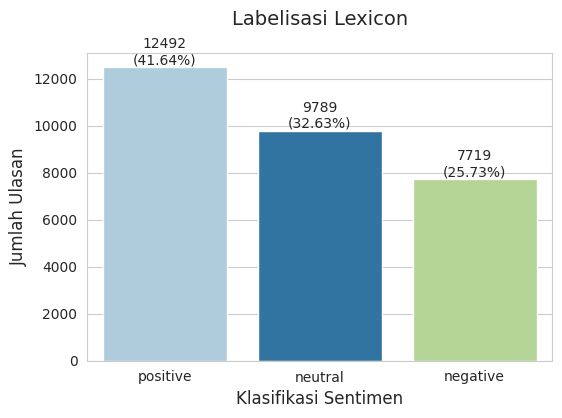

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sentiment_count = df_v1['label'].value_counts()
sns.set_style('whitegrid')
colors = plt.cm.Paired(range(len(sentiment_count)))

fig, ax = plt.subplots(figsize=(6, 4))
bars = sns.barplot(
    x=sentiment_count.index,
    y=sentiment_count.values,
    palette=colors
)

plt.title('Labelisasi Lexicon', fontsize=14, pad=20)
plt.xlabel('Klasifikasi Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)

total = len(df_v1['label'])
for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})',
            ha='center', va='bottom')

plt.show()


In [14]:
# export to tsv
df_v1.to_csv('prefinal.tsv', sep='\t', index=False)

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

df_path = 'prefinal.tsv'
df_v2 = pd.read_csv(df_path, sep='\t')

df_v2 = pd.DataFrame(df_v2[['review_text_normalizedjoin', 'label']])

label_encoder = LabelEncoder()
df_v2['label_num'] = label_encoder.fit_transform(df_v2['label'])

# Simpan teks ulasan asli sebelum melakukan SMOTE
df_v2['original_text'] = df_v2['review_text_normalizedjoin']

import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")


tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

df_v2 = df_v2[df_v2['review_text_normalizedjoin'].notnull()]
# Fungsi untuk mengonversi teks ke embedding
def get_embeddings(text):
    if not isinstance(text, str):
        return np.zeros(768)
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


# Mendapatkan embeddings untuk semua ulasan
df_v2['embeddings'] = df_v2['review_text_normalizedjoin'].apply(get_embeddings)

# Mengubah embeddings menjadi array numpy
X = np.vstack(df_v2['embeddings'].values)
y = df_v2['label_num'].values

# Menerapkan SMOTE untuk menangani ketidakseimbangan kelas
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Konversi data resample ke DataFrame
df_resampled = pd.DataFrame(X_res, columns=[f'embed_{i}' for i in range(X_res.shape[1])])
df_resampled['label_num'] = y_res

# Ubah kembali label numerik menjadi teks
df_resampled['label'] = label_encoder.inverse_transform(df_resampled['label_num'])

# Tambahkan kembali teks ulasan yang asli berdasarkan label_num hasil resampling
df_resampled['review_text_normalizedjoin'] = df_resampled['label_num'].apply(
    lambda x: df_v2[df_v2['label_num'] == x]['original_text'].sample().values[0]
)

# Hapus kolom embedding sebelum diekspor
df_final = df_resampled[['review_text_normalizedjoin', 'label']]

# export to tsv
df_final.to_csv('prefinal1.tsv', sep='\t', index=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

<ipython-input-15-9c116586e77f>:20: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  bars = sns.barplot(


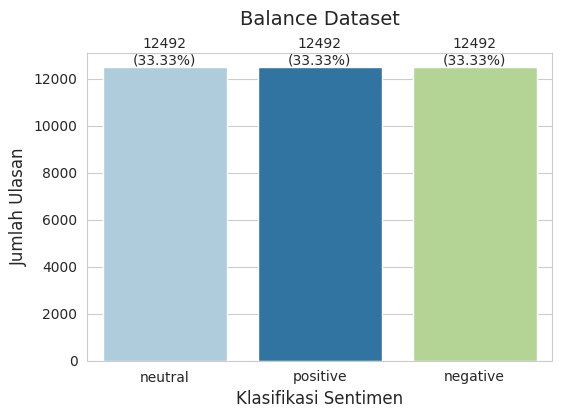

In [15]:
# Baca file TSV hasil resampling
df_path = 'prefinal1.tsv'
df_v01 = pd.read_csv(df_path, sep='\t')

# Ambil kolom yang diperlukan
df_v01 = pd.DataFrame(df_v01[['review_text_normalizedjoin', 'label']])
df_v01

# Visualisasi distribusi label
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sentiment_count = df_v01['label'].value_counts()
sns.set_style('whitegrid')
colors = plt.cm.Paired(range(len(sentiment_count)))

fig, ax = plt.subplots(figsize=(6, 4))
bars = sns.barplot(
    x=sentiment_count.index,
    y=sentiment_count.values,
    palette=colors
)

plt.title('Balance Dataset', fontsize=14, pad=20)
plt.xlabel('Klasifikasi Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)

total = len(df_v01['label'])
for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()


In [18]:
from nltk.probability import FreqDist

# Hitung frekuensi kata dari corpus
corpus_freq_dist = FreqDist(corpus.split())
corpus_freq = pd.DataFrame(corpus_freq_dist.most_common(20), columns=['word', 'freq'])


Count of unique words in corpus: 10122
Count of unique words in corpus: 10122


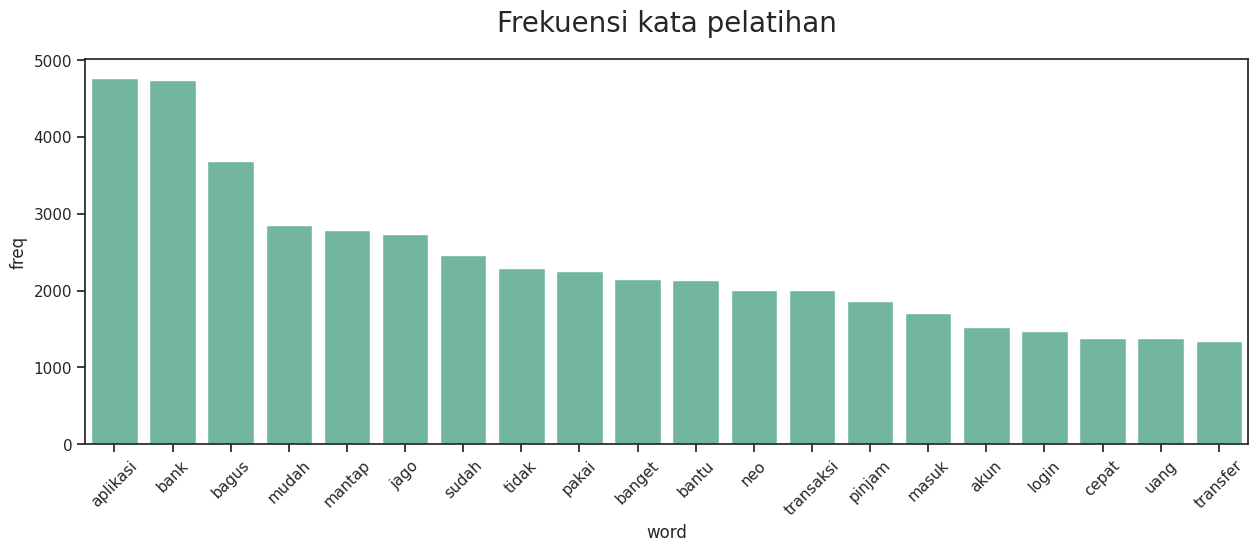

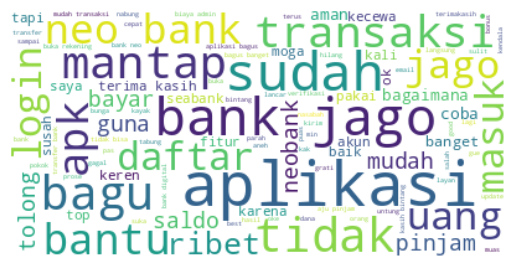

In [19]:
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud


def make_corpus(column):
    corpus_list = []
    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)
    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+', ' ', corpus)  # replace double whitespace with one
    return corpus

# Takes a while
corpus = make_corpus(df_v1.review_text_normalizedjoin)

# counting unique words
corpus_set = set(corpus.split(' '))
print(f'Count of unique words in corpus: {len(corpus_set)}')

# counting unique words (lagi)
corpus_set = set(corpus.split(' '))
print(f'Count of unique words in corpus: {len(corpus_set)}')

# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1, figsize=(15, 5))
sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Frekuensi kata pelatihan')
ax1.tick_params(axis='x', rotation=45)
# sns.despine(ax=ax1)

plt.show()

# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [20]:
# export to tsv
df_final.to_csv('prefinal.tsv', sep='\t', index=False)

import pandas as pd
import numpy as np

df_path = 'prefinal1.tsv'
df_v2 = pd.read_csv(df_path, sep='\t')
df_v2.head()
df_v2['label'].value_counts()

df_v2 = pd.DataFrame(df_v2[['review_text_normalizedjoin', 'label']])
df_v2

# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.label, random_state=42)
val_set, test_set = train_test_split(val_set, test_size=0.5, stratify=val_set.label, random_state=42)

print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)


Train shape: (26233, 2)
Val shape: (5621, 2)
Test shape: (5622, 2)


In [21]:
import random
import numpy as np
import torch


###
# common functions
###

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(27)




In [22]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    config=config
)

# Struktur model
count_param(model)

# Dataset paths
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

# Fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(
    train_dataset_path,
    tokenizer,
    lowercase=True
)

valid_dataset = DocumentSentimentDataset(
    valid_dataset_path,
    tokenizer,
    lowercase=True
)

test_dataset = DocumentSentimentDataset(
    test_dataset_path,
    tokenizer,
    lowercase=True
)

train_loader = DocumentSentimentDataLoader(
    dataset=train_dataset,
    max_seq_len=512,
    batch_size=32,
    num_workers=16,
    shuffle=True
)

valid_loader = DocumentSentimentDataLoader(
    dataset=valid_dataset,
    max_seq_len=512,
    batch_size=32,
    num_workers=16,
    shuffle=False
)

test_loader = DocumentSentimentDataLoader(
    dataset=test_dataset,
    max_seq_len=512,
    batch_size=32,
    num_workers=16,
    shuffle=False
)

# Label mapping
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)  # word to index
print(i2w)  # index to word


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(Epoch 1) TRAIN LOSS:0.5003 LR:0.00000300: 100%|██████████| 820/820 [03:03<00:00,  4.47it/s]


(Epoch 1) TRAIN LOSS:0.5003 ACC:0.80 F1:0.80 REC:0.80 PRE:0.80 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2994 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88: 100%|██████████| 176/176 [00:19<00:00,  8.84it/s]


(Epoch 1) VALID LOSS:0.2994 ACC:0.88 F1:0.88 REC:0.88 PRE:0.88


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) TRAIN LOSS:0.2465 LR:0.00000300: 100%|██████████| 820/820 [03:10<00:00,  4.30it/s]


(Epoch 2) TRAIN LOSS:0.2465 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2027 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93: 100%|██████████| 176/176 [00:20<00:00,  8.64it/s]


(Epoch 2) VALID LOSS:0.2027 ACC:0.93 F1:0.93 REC:0.93 PRE:0.93


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) TRAIN LOSS:0.1587 LR:0.00000300: 100%|██████████| 820/820 [03:10<00:00,  4.31it/s]


(Epoch 3) TRAIN LOSS:0.1587 ACC:0.94 F1:0.94 REC:0.94 PRE:0.94 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.1564 ACC:0.95 F1:0.95 REC:0.95 PRE:0.95: 100%|██████████| 176/176 [00:19<00:00,  8.82it/s]


(Epoch 3) VALID LOSS:0.1564 ACC:0.95 F1:0.95 REC:0.95 PRE:0.95


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) TRAIN LOSS:0.1042 LR:0.00000300: 100%|██████████| 820/820 [03:11<00:00,  4.29it/s]


(Epoch 4) TRAIN LOSS:0.1042 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.1343 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96: 100%|██████████| 176/176 [00:20<00:00,  8.55it/s]


(Epoch 4) VALID LOSS:0.1343 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 5) TRAIN LOSS:0.0711 LR:0.00000300: 100%|██████████| 820/820 [03:09<00:00,  4.32it/s]


(Epoch 5) TRAIN LOSS:0.0711 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.1255 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96: 100%|██████████| 176/176 [00:19<00:00,  8.86it/s]


(Epoch 5) VALID LOSS:0.1255 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 6) TRAIN LOSS:0.0502 LR:0.00000300: 100%|██████████| 820/820 [03:09<00:00,  4.32it/s]


(Epoch 6) TRAIN LOSS:0.0502 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.1295 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96: 100%|██████████| 176/176 [00:20<00:00,  8.71it/s]


(Epoch 6) VALID LOSS:0.1295 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 7) TRAIN LOSS:0.0399 LR:0.00000300: 100%|██████████| 820/820 [03:11<00:00,  4.29it/s]


(Epoch 7) TRAIN LOSS:0.0399 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.1287 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97: 100%|██████████| 176/176 [00:19<00:00,  8.97it/s]


(Epoch 7) VALID LOSS:0.1287 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 8) TRAIN LOSS:0.0292 LR:0.00000300: 100%|██████████| 820/820 [03:11<00:00,  4.28it/s]


(Epoch 8) TRAIN LOSS:0.0292 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.1338 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97: 100%|██████████| 176/176 [00:24<00:00,  7.07it/s]


(Epoch 8) VALID LOSS:0.1338 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 9) TRAIN LOSS:0.0262 LR:0.00000300: 100%|██████████| 820/820 [03:11<00:00,  4.29it/s]


(Epoch 9) TRAIN LOSS:0.0262 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.1459 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96: 100%|██████████| 176/176 [00:20<00:00,  8.75it/s]


(Epoch 9) VALID LOSS:0.1459 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96


  0%|          | 0/820 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 10) TRAIN LOSS:0.0229 LR:0.00000300: 100%|██████████| 820/820 [03:10<00:00,  4.30it/s]


(Epoch 10) TRAIN LOSS:0.0229 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00000300


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.1300 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97: 100%|██████████| 176/176 [00:19<00:00,  8.95it/s]


(Epoch 10) VALID LOSS:0.1300 ACC:0.97 F1:0.97 REC:0.97 PRE:0.97


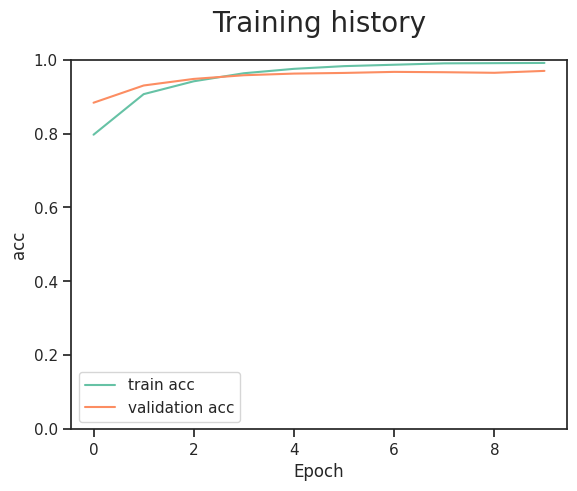

In [23]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict  # ✅ ini dia

# dll...



# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

# Train
n_epochs = 10
history = defaultdict(list)

for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device='cuda'
        )

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description(
            "(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format(
                (epoch+1),
                total_train_loss / (i+1),
                get_lr(optimizer)
            )
        )

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print(
        "(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format(
            (epoch+1),
            total_train_loss / (i+1),
            metrics_to_string(metrics),
            get_lr(optimizer)
        )
    )

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device='cuda'
        )

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

        metrics = document_sentiment_metrics_fn(list_hyp, list_label)
        pbar.set_description(
            "VALID LOSS:{:.4f} {}".format(
                total_loss / (i+1),
                metrics_to_string(metrics)
            )
        )

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(
        "(Epoch {}) VALID LOSS:{:.4f} {}".format(
            (epoch+1),
            total_loss / (i+1),
            metrics_to_string(metrics)
        )
    )

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


In [24]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t',
names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

In [25]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)
total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(
        model, batch_data[:-1], i2w=i2w, device='cuda'
    )
    pred += batch_hyp

# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)


  0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 176/176 [00:14<00:00, 11.75it/s]


              precision    recall  f1-score   support

    positive       0.97      0.98      0.97      1873
     neutral       0.96      0.95      0.96      1874
    negative       0.98      0.97      0.98      1874

    accuracy                           0.97      5621
   macro avg       0.97      0.97      0.97      5621
weighted avg       0.97      0.97      0.97      5621



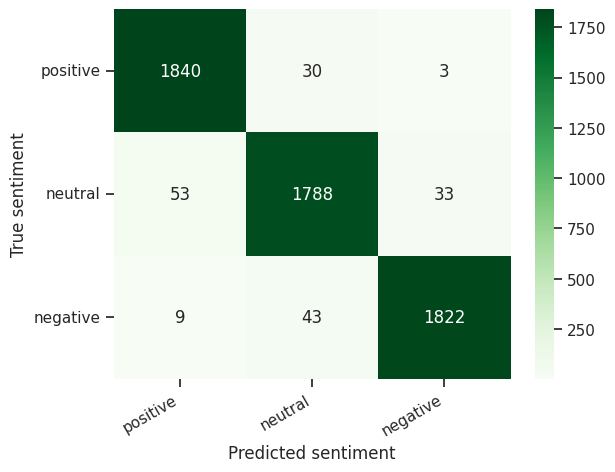

In [26]:
from sklearn.metrics import confusion_matrix, classification_report


val_real = val_df.category
val_pred = val_df.pred
test_real = test_df.category
test_pred = test_df.pred

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(
    cm,
    index=['positive', 'neutral', 'negative'],
    columns=['positive', 'neutral', 'negative']
)

show_confusion_matrix(df_cm)

print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))


In [27]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')


              precision    recall  f1-score   support

    positive       0.96      0.98      0.97      1874
     neutral       0.96      0.95      0.95      1874
    negative       0.99      0.97      0.98      1874

    accuracy                           0.97      5622
   macro avg       0.97      0.97      0.97      5622
weighted avg       0.97      0.97      0.97      5622



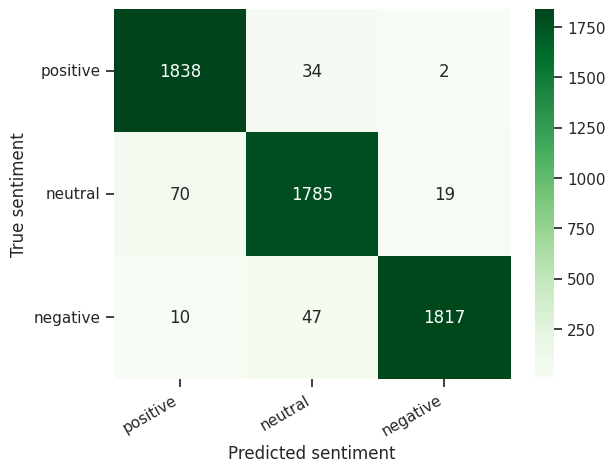

In [28]:
cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral',
'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)
print(classification_report(test_real, test_pred,
target_names=['positive', 'neutral', 'negative']))

In [29]:
import torch

# Assuming 'model' is your trained PyTorch model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/sentiment_analisis_bank.pth'

# Save the model's state dictionary
torch.save(model, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Colab Notebooks/sentiment_analisis_bank.pth


In [37]:
import torch
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# Buat ulang konfigurasi model sesuai jumlah label
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1', num_labels=3)

# Inisialisasi model dengan konfigurasi
model = BertForSequenceClassification(config)

# Load state_dict yang disimpan
# Changed from loading the entire model object to loading the state dictionary
model.load_state_dict(torch.load("/content/sentiment_analisis_bank.pth", map_location=torch.device('cpu')))
model.eval()

# Mapping label
id2label = {0: "positive", 1: "neutral", 2: "negative"}

# Kalimat uji
kalimat_list = [
    "sejauh ini aplikasinya  maintenancenya sangat mengganggu",
    "lemot harus di perbaiki supaya lancar di ringankan terimakasih",
    "keren banget aplikasinya"
]

# Uji kalimat
for kalimat in kalimat_list:
    inputs = tokenizer(kalimat, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        skor, pred_id = torch.max(probs, dim=1)
        label = id2label[pred_id.item()]
        print(f"Text: {kalimat} | Label : {label} ({skor.item()*100:.3f}%)")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Text: sejauh ini aplikasinya  maintenancenya sangat mengganggu | Label : negative (99.442%)
Text: lemot harus di perbaiki supaya lancar di ringankan terimakasih | Label : neutral (93.442%)
Text: keren banget aplikasinya | Label : positive (81.833%)
